# Exploration of the DFG-GEPRIS dataset

The dataset contains data about research (and other) proposals funded by [Deutsche Forschungsgemeinshaft (DFG)](https://www.dfg.de) over the years. The data was scraped using the REST API of the [GEPRIS](https://gepris.dfg.de/gepris/OCTOPUS?task=showKatalog) database provided by DFG and stored as pandas dataframe. In particular, I store projects and persons as two separate tables linked by corresponding field (i.e. projects table contains field PIs listing all involved persons, and persons table contains field project_ids containing all projects person is involved in). In addition, some extra fields are added to both tables for convinience (including those useful to link both tables, i.e. lists of projects for given person and lists of involved persons for each project). Note that even if all the information is already available at GEPRIS, but I dropped personal information (i.e. names) to avoid privacy issues (and names of individuals are in any case probably not relevant for statistical studies). For the purpose of illustrations here I use, however, named version as it's not fun to look at numbers only.

## Description of the parsed datset
Besides scraping, some data cleaning was performed, and, in addition, some extra processing was done to add several fields:

1) gender of persons behind the projects was derived based on their name using either title suffix (Profesor vs Profesorin) or parsed using OpenAI API as motivated by this [arxiv preprint](https://arxiv.org/pdf/2312.00805) where it is shown that ChatGPT is as good as dedicated solutions for this task.
2) Knowledge area codes according to [DFG classification](https://www.dfg.de/resource/blob/175336/46d0a8c5c14d0f6530da28b4d25bf589/fachsystematik-2020-2024-en-grafik-data.pdf) were assigned for each project (from GEPRIS) and person (median of all projects person is involved in).
3) Adresses in GEPRIS were resolved to geographical locations with the help of [geopy](https://geopy.readthedocs.io/en/stable/) (Bing and OSM as geocoders). Here the problem is often that adress can not be readily separated from affiliation in many cases. I used, therefore, OpenAI api (gpt-3.5) to parse the adresses to affiliation/address before resolving locations. Affiliation is stored as a separate field.
4) estimated full-time equivalent positions and budget. DFG does not disclose how much money was actually awarded, so that's just a guess based on the typical pattern of requesting one position per PI for the duration of the project. The budget is then estimated by multiplying number of FTE by 250k per year (2024 prices) + 30% overhead. Appears to match overall budget reported for 2010-2024 if all estimates are co-added. 
5) [jina-embeddings-v2](https://jina.ai/news/jina-ai-launches-worlds-first-open-source-8k-text-embedding-rivaling-openai/) were generated for concatenated project title + description (+ descriptions of nested projects). In particular [bi-lingual en-de version](https://huggingface.co/jinaai/jina-embeddings-v2-base-de) was used. The motivation for Jina instead of OpenAI embeddings is performance + ability to generate jina's locally, which is fun both for learning and cost reasons.


## First look at the table content

So, let's take a look at projects/persons datasets and do some basic data exploration

In [1]:
import pandas as pd
df_projects = pd.read_pickle('gepris_projects.pkl')
# df_persons = pd.read_pickle('gepris_persons.pkl')
df_persons = pd.read_pickle('persons_gender_extloc.pkl')

In [2]:
df_projects.head()

,project_id,title,description,area,PIs,lead_inst,sub_projects,program_type,start,stop,...,N_PI,estimated_fte,estimated_budget,PI_countries,PI_bundeslaender,PI_cities,PI_gender,PI_locations,lat,lon
0,443637168,Tonminerale als Sorbenten für hydrophobe organ...,"Hydrophobe organische Chemikalien (HOC), wie z...",Bodenwissenschaften,"[411276265, 1888464]",NaN,[],Sachbeihilfen,2020.0,2020.0,...,2,2.0,0.219883,"[de, at]","[Hessen, None]","[Gießen, Wien]","[m, m]","[(50.5708692, 8.6738591), (48.2375392, 16.3317...",50.570869,8.673859
1,246298980,Begriffswandel als eine Form kognitiver Dynamik,Es ist eine der zentralen Aufgaben der Philoso...,Theoretische Philosophie,[15950860],NaN,[],Sachbeihilfen,2014.0,2018.0,...,1,4.0,0.439767,[de],[None],[None],[m],"[(nan, nan)]",NaN,NaN
2,186922621,Mechanistische Aufklärung der StrukturReaktivi...,Die detaillierten Reaktionsmechanismen redoxak...,"Anorganische Molekülchemie - Synthese, Charakt...",[1043784],NaN,[],Sachbeihilfen,2010.0,2013.0,...,1,3.0,0.329825,[de],[Bayern],[Erlangen],[m],"[(49.5756166, 11.0284748)]",49.575617,11.028475
3,5245914,Agentenbasierte Steuerung und Koordination fun...,Keine Zusammenfassung vorhanden,Accounting und Finance,[1683491],NaN,['5469920'],Schwerpunktprogramme,2000.0,2009.0,...,1,9.0,0.989475,[de],[Baden-Württemberg],[Mannheim],[m],"[(49.48101445, 8.469925947558208)]",49.481014,8.469926
4,27952951,Nitridierung Scandiumdotierter Zirconiumoxide ...,Die Nitridierung der Ordnungsphasen im System ...,"Festkörper- und Oberflächenchemie, Materialsyn...",[1273700],NaN,['5471621'],Schwerpunktprogramme,2006.0,2010.0,...,1,4.0,0.439767,[de],[Baden-Württemberg],[Tübingen],[m],"[(48.536481, 9.0356215)]",48.536481,9.035621


In [3]:
df_persons.head()

,person_id,name,gender,affilation,adress,plz,lat,lon,country,Bundesland,city,subject_area_code,project_ids,n_projects
0,1357362,Professor Dr.Ing. Peter Werner Gold,m,Rheinisch-Westfälische Technische Hochschule A...,"Schinkelstraße 10, 52062 Aachen",52062,50.779545,6.075668,de,Nordrhein-Westfalen,Aachen,41.0,"[5362031, 5381285, 5423789, 5481663, 5133156, ...",9
1,1717413,"Professorin Dr. Elly Margaret Tanaka, Ph.D.",f,Österreichische Akademie der Wissenschaften IM...,"Dr. Bohr-Gasse 3, 1030 Wien, Österreich",NaN,48.189450,16.401994,at,None,Wien,22.0,"[24185540, 22137416, 269024926, 157044246, 283...",19
2,2026073,Professor Dr. Kay Königsmann,m,"Albert-Ludwigs-Universität Freiburg, Physikali...","Hermann-Herder-Straße 3, 79104 Freiburg",79104,48.002215,7.851494,de,Baden-Württemberg,Freiburg im Breisgau,32.0,[454969],1
3,1415157,Professor Dr. Harald Luksch,m,"Technische Universität München, TUM School of ...","Liesel-Beckmann-Straße 4, 85354 Freising",85354,48.402225,11.724997,de,Bayern,Freising,22.0,"[269673298, 5382445, 532683878, 5138498, 54570...",6
4,1422313,Professor Dr. HansPeter Grossart,m,Leibniz-Institut für Gewässerökologie und Binn...,"Zur alten Fischerhütte 2, 16775 Stechlin",16775,53.141246,13.030608,de,Brandenburg,Rheinsberg,34.0,"[39400205, 329628835, 273732160, 5422726, 2875...",28


The applications of this dataset are up to creativity of the explorer. One common task is assessment of the gender balance in various research fields:

In [4]:
# the fields themselves (per DFG)
fachgebiete = {11: ('Geisteswissenschaften','Humanities'),
               12: ('Sozial- und Verhaltens- wissenschaften', 'Social and Behavioural Sciences'),
               21: ('Biologie','Biology'),
               22: ('Medizin','Medicine'),
               23: ('Agrar-, Forstwissen- schaften und Tiermedizin','Agriculture, Forestry and Veterinary Medicine'),
               31: ('Chemie','Chemistry'),
               32: ('Physik', 'Physics'),
               33: ('Mathematik','Mathematics'),
               34: ('Geowissenschaften','Geosciences'),
               41: ('Maschinenbau und Produktionstechnik','Mechanical and Industrial Engineering'),
               42: ('Wärmetechnik/ Verfahrenstechnik','Thermal Engineering/ Process Engineering'),
               43: ('Materialwissenschaft und Werkstofftechnik','Materials Science and Engineering'),
               44: ('Informatik, System- und Elektrotechnik','Computer Science, Systems and Electrical Engineering'),
               45: ('Bauwesen und Architektur','Construction Engineering and Architecture')}


In [5]:
def female_percentile(area_code):
    area_genders = df_projects.PI_gender[df_projects.subject_area_code==area_code].sum()
    return 100.0*area_genders.count('f')/len(area_genders)

In [6]:
x = sorted(fachgebiete.keys()) # DFG sorts from humanities to technicalities, so its feasible
y = [female_percentile(subj) for subj in x]

Text(0.5, 1.0, 'Fraction of female PIs/coPIs in DFG-funded projects')

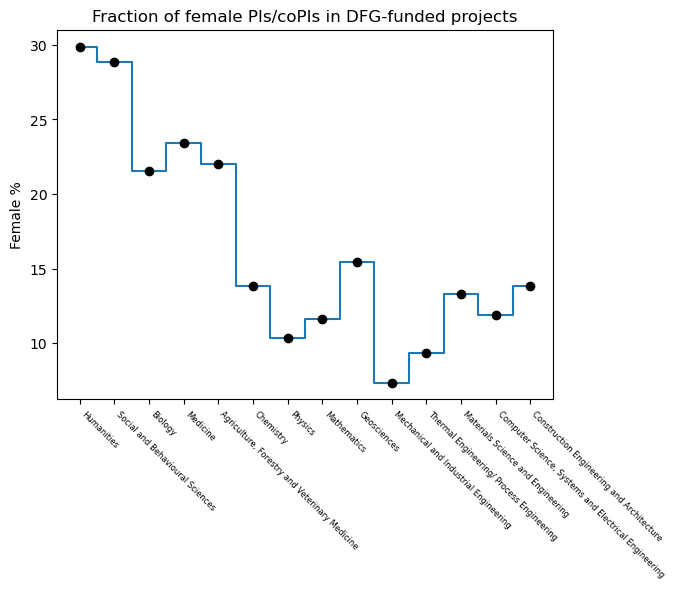

In [7]:
import pylab as plt
import numpy as np
xx = np.arange(0,len(x))
plt.plot(xx,y,ds='steps-mid');
plt.plot(xx,y,'ko');
plt.xticks(xx,[fachgebiete[i][1] for i in x],rotation=-45,size=6,ha='left'); #use english names
plt.ylabel("Female %");
plt.title("Fraction of female PIs/coPIs in DFG-funded projects")

As one can see, DFG sorting of subject areas is also correlated with female fraction. Another perspective on the same data can be obtained if one looks at how things change over time:

In [8]:
def female_percentile_yr(start_year, stop_year, area_code):
    area_genders = df_projects.PI_gender[(df_projects.subject_area_code==area_code)*(df_projects.start>=start_year)*(df_projects.stop<=stop_year)]
    if len(area_genders)==0:
        return np.nan
    else:
        area_genders = area_genders.sum()
        return 100.0*area_genders.count('f')/len(area_genders)

time_bins = np.arange(1994,df_projects.stop.max()+1,5) # bin over 5 years intervals. Reliable data only starts after 1995
def female_percentile_yrs(area_code,time_bins=time_bins):
    result = []
    for i in range(len(time_bins)-1):
        result.append((0.5*(time_bins[i]+time_bins[i+1]),female_percentile_yr(time_bins[i],time_bins[i+1],area_code)))
    return np.transpose(result) # return both time and value

Text(0, 0.5, 'Female %')

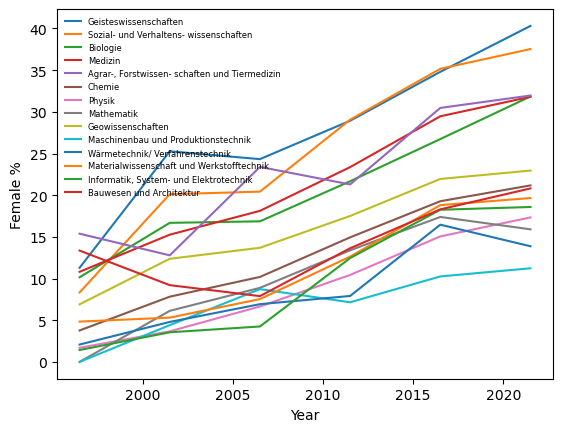

In [9]:
for fg in x:
    t,v = female_percentile_yrs(fg)
    plt.plot(t,v,label=fachgebiete[fg][0])
plt.legend(frameon=False,fontsize=6)
plt.xlabel('Year')
plt.ylabel('Female %')

As one can see, all fields slowly but surely move in the direction of gender equality (~50% for Germany), but some have a longer way to go than the others. We can even calculate when perfect gender balance will be achieved in each of the areas by doing simple linear regression on the plotted data and extrapolating:

In [10]:
t0 = 1994
tnow = 2024
t50 = {}
for fg in x:
    t,v = female_percentile_yrs(fg)
    t,v = t[abs(v)>=0],v[abs(v)>=0] # filter out nans
    t50[fg] = tnow+(50-v[-1])/np.polyfit(t-t0,v,1)[0] # average derivative through linear regression

Text(0.5, 1.0, 'Projected year when 50% gender balance will be achieved')

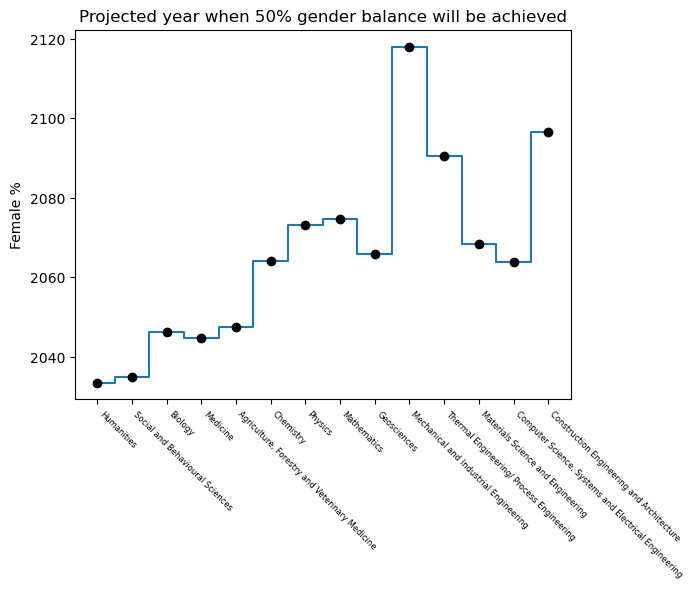

In [11]:
import pylab as plt
import numpy as np
xx = np.arange(0,len(x))
plt.plot(xx,[t50[i] for i in x],ds='steps-mid');
plt.plot(xx,[t50[i] for i in x],'ko');
plt.xticks(xx,[fachgebiete[i][1] for i in x],rotation=-45,size=6,ha='left'); #use english names
plt.ylabel("Female %");
plt.title("Projected year when 50% gender balance will be achieved")

Another generation for physics, and more still for engineering disciplines! And so on. One can, for instance, repeat the same analysis by looking only at principal investigators rather than all co-investigators, and adjust the overall view for gender balance in relevant age bins at time of funding/school/university, etc. 

Another area where the dataset can be useful is analysis of the connections between entities (geographical, institutional or personal). For instance, some basic collaboration patterns (like total number of Co-Is) can be derived directly from the table (again per subject area and only for Sachbeihilfen projects as big collaborations for big instruments are typically used):

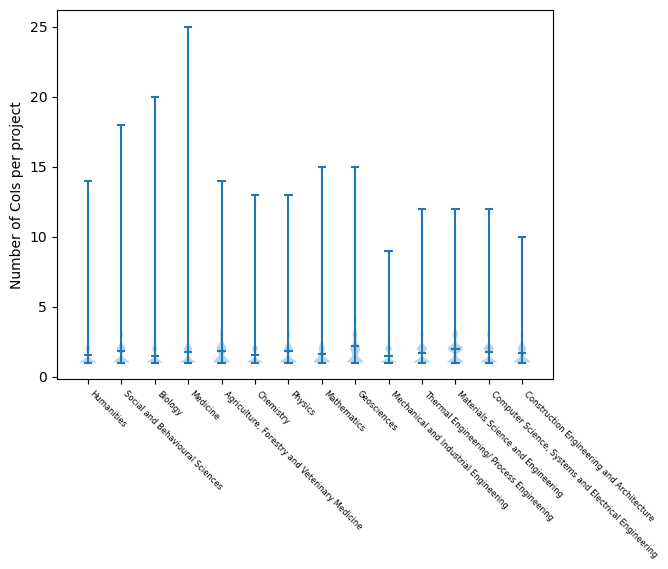

In [12]:
violin_data = [[max(1,x) for x in df_projects.PIs[(df_projects.subject_area_code==fg)*(df_projects.program_type=='Sachbeihilfen')].apply(lambda x: len(x))] for fg in x] # clip projects with no PIs to at least one PI. Those are just publishing proposals from libraries etc
plt.violinplot(violin_data,positions=xx,showmeans=True);
plt.xticks(xx,[fachgebiete[i][1] for i in x],rotation=-45,size=6,ha='left'); #use english names
plt.ylabel("Number of CoIs per project");

One can i.e. visually see that in most cases we have 1-3 but up to ~30 CoIs, with balance varying between the field. It's clear i.e. that humanities are pretty individualistic, whereas engineereng sciences tend to have 2-3 CoIs and medicine projects are often built around larger collaborations. 


## Geospatial exploration and visualization

One can also take a look at geographical distribution of projects across various project areas:

In [13]:
import geopandas as gpd
bld = gpd.read_file('vg2500_bld.shp') # read bundeslander boundaries

top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Cologne': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'Munich': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nuremberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

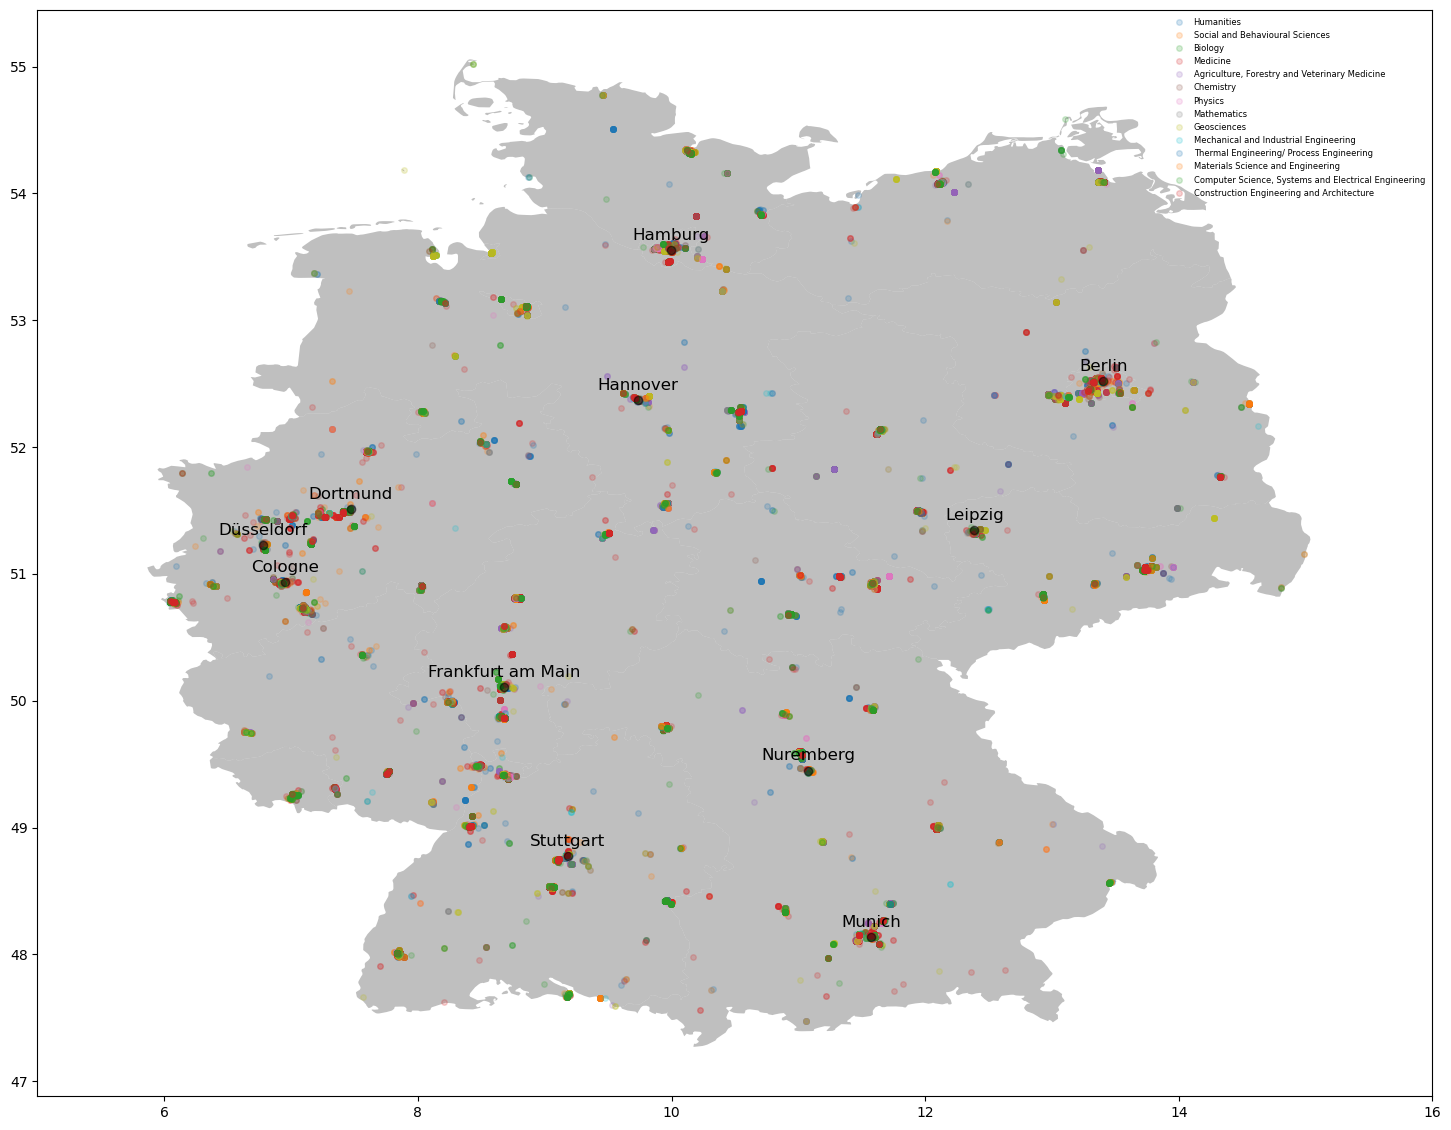

In [14]:
bld.plot(aspect='equal',color='gray',alpha=0.5,figsize=(18,18))
for fg in fachgebiete.keys():
    m = (df_projects.subject_area_code==fg)*(df_projects.PI_countries.apply(lambda x: len(x)==1 and x[0]=='de')*(df_projects.lon>=5))
    plt.plot(df_projects.lon[m],df_projects.lat[m],'.',alpha=0.2,ms=8,label=fachgebiete[fg][1])
plt.xlim(5,16)
plt.legend(frameon=False,fontsize=6)
ax = plt.gca()
for c in top_cities.keys():
    # Plot city name.
    ax.text(
        x=top_cities[c][0], 
        # Add small shift to avoid overlap with point.
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )
    # Plot city location centroid.
    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

One can i.e. immideately see the main cities and main centers of various disciplines (i.e. university-cities) of course, the map is a bit messy with 140k points across areas. A better idea might be to visualize the map for individual subjects, or do more sophisticated visualization with more appropriate (for a task) tools. For instance, one can integrate by Bundesland (state). The geodata I have does not have names encoded, so derive indices through sorting by area:

In [15]:
areasorted_bl = {'Bremen':2,'Hamburg':0,'Berlin':9,'Saarland':8,
                 'Schleswig-Holstein':15,'Thüringen':14,'Sachsen':12,
                 'Rheinland-Pfalz':5,'Sachsen-Anhalt':4,
                 'Hessen':13, 'Mecklenburg-Vorpommern':11,
                 'Brandenburg':10,'Nordrhein-Westfalen':6,
                 'Baden-Württemberg':3,'Niedersachsen':1, 'Bayern':7}
#[(x,bld['geometry'].iloc[areasorted_bl[x]].area) for x in areasorted_bl.keys()] # if verification is needed

Now can generate geo-dataframe containing bundesland name and total funding (perhaps in area of interest):

/var/folders/l9/yhh7ptgx6dqb97khkd08bkmw0000gn/T/ipykernel_34179/288177150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum.loc[:,'bundesland'] = df_sum['PI_bundeslaender'].apply(lambda x:x[0])


,bundesland,estimated_budget,geometry
0,Baden-Württemberg,1438.476750,"POLYGON ((8.66673 52.52149, 8.70289 52.50053, ..."
1,Bayern,1167.140720,"POLYGON ((10.47207 47.56964, 10.47319 47.57081..."
2,Berlin,1401.536350,"POLYGON ((13.61192 52.54332, 13.62461 52.53797..."
3,Brandenburg,152.708973,"POLYGON ((13.87357 53.47515, 13.9161 53.45652,..."
4,Bremen,48.374333,"MULTIPOLYGON (((8.52976 53.2164, 8.55399 53.20..."
5,Hamburg,278.152413,"MULTIPOLYGON (((10.19114 53.72299, 10.1821 53...."
6,Hessen,719.018492,"POLYGON ((11.63624 53.0068, 11.64091 53.00601,..."
7,Mecklenburg-Vorpommern,105.763882,"MULTIPOLYGON (((12.66717 54.44292, 12.67209 54..."
8,Niedersachsen,498.585452,"MULTIPOLYGON (((8.68962 53.87999, 8.69297 53.8..."
9,Nordrhein-Westfalen,1694.640830,"MULTIPOLYGON (((9.64634 49.77782, 9.63806 49.7..."


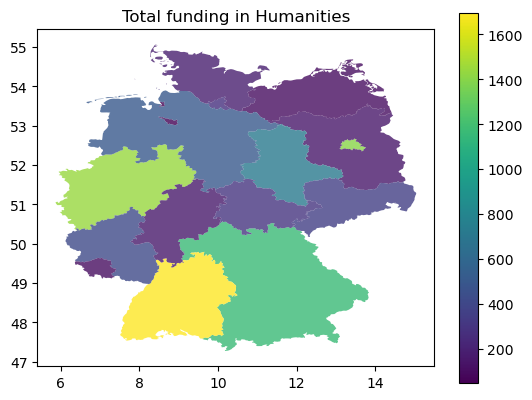

In [16]:
# select only projects with bundesland specified and area code=32 (physics)
fg = 11
df_sum = df_projects[(df_projects['PI_bundeslaender'].apply(lambda x: len(x)>=1 and x[0] or np.nan).notna())*(df_projects.subject_area_code==fg)]
df_sum.loc[:,'bundesland'] = df_sum['PI_bundeslaender'].apply(lambda x:x[0])
df_sum = df_sum.groupby('bundesland')['estimated_budget'].sum().reset_index()
#add geometry column picking correct polygon for each BL
df_sum['geometry']=df_sum['bundesland'].apply(lambda x: bld.iloc[areasorted_bl[x]])
#convert to geopandas frame
df_sum = gpd.GeoDataFrame(df_sum)
df_sum.plot(
    column='estimated_budget', 
    legend=True, 
    alpha=0.8,
    aspect='auto'
);
plt.title(f"Total funding in {fachgebiete[fg][1]}");
df_sum

Obviously, one can also do additional filtering and do some temporal exploration of the geo-shaped data. For instance, one can identify developing and regressing states in some knowledge area by comparing maps integrated over some time periods, i.e. for instance in last 5 years and 5 years prior to that:

/var/folders/l9/yhh7ptgx6dqb97khkd08bkmw0000gn/T/ipykernel_34179/2363415231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum.loc[:,'bundesland'] = df_sum['PI_bundeslaender'].apply(lambda x:x[0])


,bundesland,estimated_budget,geometry
0,Baden-Württemberg,-13.841369,"POLYGON ((8.66673 52.52149, 8.70289 52.50053, ..."
1,Bayern,-2.785146,"POLYGON ((10.47207 47.56964, 10.47319 47.57081..."
2,Berlin,12.349398,"POLYGON ((13.61192 52.54332, 13.62461 52.53797..."
3,Brandenburg,11.940299,"POLYGON ((13.87357 53.47515, 13.9161 53.45652,..."
4,Bremen,28.888889,"MULTIPOLYGON (((8.52976 53.2164, 8.55399 53.20..."
5,Hamburg,-133.121019,"MULTIPOLYGON (((10.19114 53.72299, 10.1821 53...."
6,Hessen,-78.099174,"POLYGON ((11.63624 53.0068, 11.64091 53.00601,..."
7,Mecklenburg-Vorpommern,61.165049,"MULTIPOLYGON (((12.66717 54.44292, 12.67209 54..."
8,Niedersachsen,-77.049180,"MULTIPOLYGON (((8.68962 53.87999, 8.69297 53.8..."
9,Nordrhein-Westfalen,-57.852349,"MULTIPOLYGON (((9.64634 49.77782, 9.63806 49.7..."


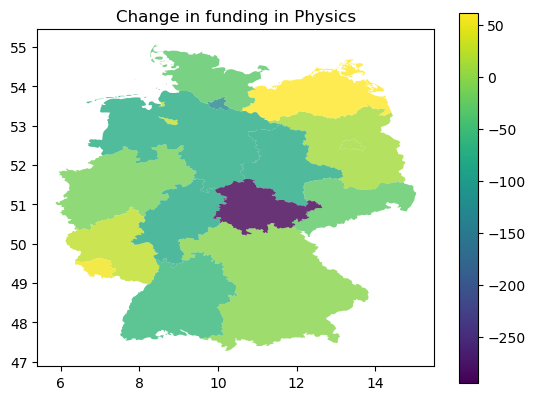

In [17]:
# select only projects with bundesland specified and area code=32 (physics)
fg = 32
df_sum = df_projects[(df_projects['PI_bundeslaender'].apply(lambda x: len(x)>=1 and x[0] or np.nan).notna())*(df_projects.subject_area_code==fg)]

df_sum.loc[:,'bundesland'] = df_sum['PI_bundeslaender'].apply(lambda x:x[0])
df_sum_recent = df_sum[df_sum.start>=2020].groupby('bundesland')['estimated_budget'].sum().reset_index()
df_sum_abit_before = df_sum[(df_sum.start>=2015)*(df_sum.stop<=2020)].groupby('bundesland')['estimated_budget'].sum().reset_index()
df_sum = df_sum_recent.sort_values(by=['bundesland'])
df_sum_abit_before = df_sum_abit_before.sort_values(by=['bundesland'])
df_sum.loc[:,'estimated_budget'] = 100.0*(df_sum.loc[:,'estimated_budget'] - df_sum_abit_before.loc[:,'estimated_budget'])/df_sum.loc[:,'estimated_budget']
#add geometry column picking correct polygon for each BL
df_sum['geometry']=df_sum['bundesland'].apply(lambda x: bld.iloc[areasorted_bl[x]])
#convert to geopandas frame

df_sum = gpd.GeoDataFrame(df_sum)
df_sum.plot(
    column='estimated_budget', 
    legend=True, 
    alpha=0.8,
    aspect='auto'
);
plt.title(f"Change in funding in {fachgebiete[fg][1]}");
df_sum

From here it's clear that Saarland is somehow shifting its focus from humanities to physics, and Thuringia in opposite direction.

Another option is use *folium* to map density of funding, for instance one can plot that separately for physics- and humanities- projects (blue and red respectively). Note that here we weight by estimated funding volume, i.e. also looking at trends like before, but rather in context of research field and on smaller spatial scale:

In [32]:
import folium
from folium.plugins import HeatMap
map = folium.Map(location=[51, 9.], tiles="CartoDB Positron", zoom_start=6)

fg = 32 # for physik
m = (df_projects.subject_area_code==fg)*(df_projects.PI_countries.apply(lambda x: len(x)==1 and x[0]=='de')*(df_projects.lon>=5))
heat_map_data = df_projects[m][['lat', 'lon', 'estimated_budget']].groupby(['lat', 'lon']).sum().reset_index().values.tolist()
# heat_map_data
fg = 11 # humanities
m = (df_projects.subject_area_code==fg)*(df_projects.PI_countries.apply(lambda x: len(x)==1 and x[0]=='de')*(df_projects.lon>=5))
heat_map_data_hum =df_projects[m][['lat', 'lon', 'estimated_budget']].groupby(['lat', 'lon']).sum().reset_index().values.tolist()

hm_physik = HeatMap(heat_map_data,gradient={0.5: 'blue', 0.0: 'lime', 0.0: 'red'})
hm_hum = HeatMap(heat_map_data_hum,gradient={0.0: 'blue', 0.0: 'lime', 0.5: 'red'})
hm_physik.add_to(map)
hm_hum.add_to(map)
map

It's fun to zoom in to cities like Heidelberg or Tubignen to see where the money flows to physics or humanities. Obviously, one can also make more interactive applications with on the flight filtering etc, but that's beyound the illustrative scope of the notebook. What is interesting to do, however, is to extract list of institutions we have here based on the geographical locations. This list can be compiled directly using GEPRIS (they have catalogue), but let's do it with person/project data we already have. To do so, lets use geopandas to create geo data frame and group that by geometry (i.e. geographical coordinates). Here we have to drop entries without adress/coordinates for the obvious reason

In [19]:
geopersons = gpd.GeoDataFrame(df_persons,geometry=gpd.points_from_xy(df_persons.lon, df_persons.lat))
geopersons = geopersons.dropna(subset=['lon','lat','affilation']).groupby('geometry').agg({'affilation':'first'}).reset_index()

In [20]:
geopersons

,geometry,affilation
0,POINT (-70.90782 -53.16257),Universidad de Magallanes
1,POINT (-70.90708 -53.16323),Instituto Antártico Chileno INACH
2,POINT (-70.87877 -53.13623),Institute of Ecology and Biodiversity
3,POINT (-68.32351 -54.82167),Centro Austral de Investigaciones Científicas ...
4,POINT (-60.1217 -51.51234),No current office address
...,...,...
14131,POINT (147.32001 -42.88),University of Tasmania
14132,POINT (147.28314 -42.8728),University of Tasmania Central Science Laboratory
14133,POINT (147.32986 -42.87839),University of Tasmania Menzies Institute for M...
14134,POINT (147.33337 -42.88632),Commonwealth Scientific and Industrial Researc...


Here we end up with around 14k institutions, which is substantially lower than in GEPRIS itself (40k). This is partly because some institutions have no adress, and partly because many institutions have several departments at the same address, and here we only take the first one. There are also some issues with data quality as entered by PIs to GEPRIS and ChatGPT being unable to recover true adress/affiliation in some cases. In principle, one shall just parse institutions table separately and cross-check with persons table to make sure no mistakes are there, but for most purposes having affiliation accurate to the level of city is ok. In other cases it might be a serios issue, especially when several quite different departments share same geographical location, i.e. when it can affect filtering based on knowledge area (if that's attached to an institution). Some examples

In [145]:
geopersons = gpd.GeoDataFrame(df_persons,geometry=gpd.points_from_xy(df_persons.lon, df_persons.lat))
geopersons = geopersons.dropna(subset=['lon','lat','affilation']).groupby('geometry').agg({'affilation':lambda x: list(x)}).reset_index()
geopersons[geopersons['affilation'].apply(lambda x: len(x)>1 and len(set(x))>1)].iloc[103].affilation

['Moffitt Cancer Center, 12902 Magnolia Drive',
 'University of South Florida, Department of Civil and Environmental Engineering, 4202 E. Fowler Avenue',
 'University of South Florida, School of Geosciences, 4202 E. Fowler Avenue',
 'University of South Florida, 4202 E. Fowler Avenue',
 'University of South Florida, School of Geosciences, 4202 E. Fowler Avenue',
 'University of South Florida, Department of Electrical Engineering, 4202 East Fowler Avenue',
 'University of South Florida, 4202 E. Fowler Avenue',
 'University of South Florida, School of Geosciences, 4202 E. Fowler Avenue']

In this case cancer center is mixed with school of geosciences and center of civil and environmental engineering, i.e. completely different knowledge areas even if adress is the same. This might be ok or not depending on application. Further on, I'll use affiliation as is without grouping by geometry, but if grouping to the level of institution as a whole is ok, that's how we could do it.

Another use case is exploration of the collaboration between the universities in different cities or Germany as a whole with other countries, for via simple pie charts:

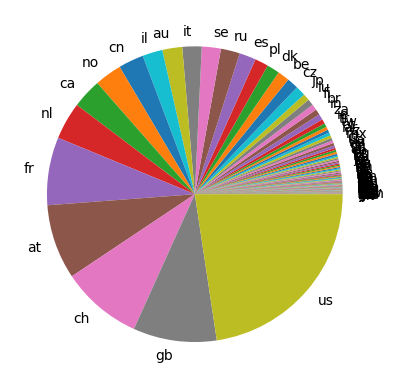

In [21]:
countries = df_projects['PI_countries'].apply(lambda x: list(set(x)-set(['de']))) #get unique countries for each project - germany
other = countries[countries.apply(lambda x: len(x)>0)].sum() # filter out only those where collaboration is present
other = [x for x in other if type(x)==str]
country,projects = np.unique(other,return_counts=True)
m = np.argsort(projects)
country,projects = country[m][10:],projects[m][10:]
plt.pie(projects,labels=country);

As one can see, most of the collaboration (over half of all projects) occurs either with direct neighboors (ch, at,fr) or US/GB. For me the big surprise was very minor collaboration with china and italy (which is there!), perhaps it's just not funded by DFG. Similar analysis obviously can be done for individual cities or even locations.

Finally, there are also embeddings. These can be used for search or clustering analyses. Clustering is a bit tricky with 140k points, so start with search. The embeddings are accessible via api or locally, make sure you set the API key or add code to load/use their model:

In [22]:
import requests
from numpy.linalg import norm

cos_sim = lambda a,b: (a @ b.T) / (norm(a)*norm(b))

jina_api_key = 'jina_063bf308314840878e82b40f78ea6776Y8Cofqr36bbZwKeG50Abq4cBiimR'
text2embed = lambda text: requests.post('https://api.jina.ai/v1/embeddings', 
                         headers={'Content-Type': 'application/json', 'Authorization': f"Bearer {jina_api_key}"}, 
                         json={'input': [text],'model': 'jina-embeddings-v2-base-de', 'encoding_type': 'float'}).json()['data'][0]['embedding']

cossim_df = lambda embd: df_projects['embedding'].apply(lambda x: cos_sim(embd,x))


In [23]:
# as an example, look for projects which concern X-ray pulsar studies

search_text = """X-ray pulsar is a type of neutron star characterized by intense magnetic fields and periodic emission of X-rays due to rapid rotation and accretion of matter from a companion star. Key aspects include accretion disks, magnetic poles, Roche lobe overflow, stellar wind capture, pulsar timing, X-ray astronomy, and neutron star physics."""

df_projects = df_projects[df_projects['embedding'].notna()]
df_projects['similarity'] = cossim_df(text2embed(search_text))

In [24]:
res = df_projects.nlargest(10,'similarity')
res

,project_id,title,description,area,PIs,lead_inst,sub_projects,program_type,start,stop,...,estimated_fte,estimated_budget,PI_countries,PI_bundeslaender,PI_cities,PI_gender,PI_locations,lat,lon,similarity
132498,39953290,Comprehensive modelling of pulse shape formati...,High energy radiation from X-ray binary pulsar...,"Optik, Quantenoptik und Physik der Atome, Mole...",[39953287],NaN,[],Sachbeihilfen,2007.0,2010.0,...,3.0,0.329825,[de],[Baden-Württemberg],[Tübingen],[m],"[(48.5345511, 9.0703136)]",48.534551,9.070314,0.628671
77028,5390430,Accretion phenomena in binary Xray pulsars / n...,Wir beantragten die Förderung eines Forschungs...,Astrophysik und Astronomie,"[1285961, 1943250, 1667145]",NaN,[],Sachbeihilfen,2002.0,2007.0,...,15.0,1.649125,"[de, ru, de]","[Baden-Württemberg, None, Bayern]","[Tübingen, Москва, Bamberg]","[m, m, m]","[(48.5345511, 9.0703136), (55.7009699, 37.5426...",48.534551,9.070314,0.566493
20396,197551926,The population of radioquiet and thermally emi...,The observed population of neutron stars is do...,Astrophysik und Astronomie,[197551921],NaN,[],Sachbeihilfen,2011.0,2016.0,...,5.0,0.549708,[de],[Brandenburg],[Potsdam],[f],"[(52.40500265, 13.10420740488076)]",52.405003,13.104207,0.556477
142499,327967367,Sternmaterie: Hyperonen und Axionen in Neutron...,Die Erzeugung von Hyperonen in Neutronensterne...,"Kern- und Elementarteilchenphysik, Quantenmech...","[87221608, 222114980]",Technische Universität München (TUM),['283604770'],Sonderforschungsbereiche,2017.0,2017.0,...,2.0,0.219883,"[de, de]","[Bayern, Bayern]","[Garching bei München, Garching bei München]","[f, m]","[(48.267132200000006, 11.67678148505157), (48....",48.267132,11.676781,0.545871
94901,418943601,Das Zusammensetzen des pulsierenden Puzzles vo...,Akkretierende Röntgenpulsare dienen als natürl...,Astrophysik und Astronomie,"[416771101, 39953287, 418944393, 418944514]",NaN,[],Sachbeihilfen,2019.0,2023.0,...,16.0,1.759067,"[de, de, nl, cn]","[Baden-Württemberg, Baden-Württemberg, None, N...","[Tübingen, Tübingen, Amsterdam, 海淀区]","[m, m, m, m]","[(48.5345511, 9.0703136), (48.5345511, 9.07031...",48.534551,9.070314,0.516265
135811,259364563,Physik in akkretierenden Röntgenpulsaren rela...,Beobachtungen von Röntgenpulsaren ermöglichen ...,Astrophysik und Astronomie,"[1667145, 234724484, 1943250]",NaN,[],Sachbeihilfen,2014.0,2023.0,...,27.0,2.968425,"[de, ru, ru]","[Bayern, None, None]","[Bamberg, Москва, Москва]","[m, m, m]","[(49.88482605, 10.888058304731356), (55.750302...",49.884826,10.888058,0.510808
128520,41489379,An accretion model for the Xray emission of cl...,Both classical as well as weak-line T Tauri st...,Astrophysik und Astronomie,[1558964],NaN,[],Sachbeihilfen,2007.0,2012.0,...,5.0,0.549708,[de],[Hamburg],[Hamburg],[m],"[(53.479650199999995, 10.239187693222139)]",53.479650,10.239188,0.508306
2025,5132086,Magnetic properties of the highspin system Mn7...,Spincluster bezeichnen magnetische Komplexmole...,Experimentelle Physik der kondensierten Materie,[1449724],NaN,['5468633'],Schwerpunktprogramme,1998.0,2006.0,...,8.0,0.879533,[de],[Baden-Württemberg],[Karlsruhe],[m],"[(49.0129051, 8.4110365)]",49.012905,8.411036,0.507217
18912,5386455,Highfield EPR spectroscopy of monomer and dime...,Keine Zusammenfassung vorhanden,Physikalische Chemie,[1415716],NaN,['5468633'],Schwerpunktprogramme,2002.0,2005.0,...,3.0,0.329825,[de],[Bayern],[Erlangen],[m],"[(49.5750643, 11.0285086)]",49.575064,11.028509,0.500527
20018,5131908,Transiente EPRSpektroskopie bei mehreren Mikro...,Keine Zusammenfassung vorhanden,Biophysik,"[1614894, 6459]",NaN,['5468633'],Schwerpunktprogramme,1998.0,2001.0,...,6.0,0.659650,"[de, de]","[Berlin, None]","[Berlin, None]","[m, m]","[(52.4556688, 13.294869), (nan, nan)]",52.455669,13.294869,0.492355


We can also plot places where people do something like that on the map:

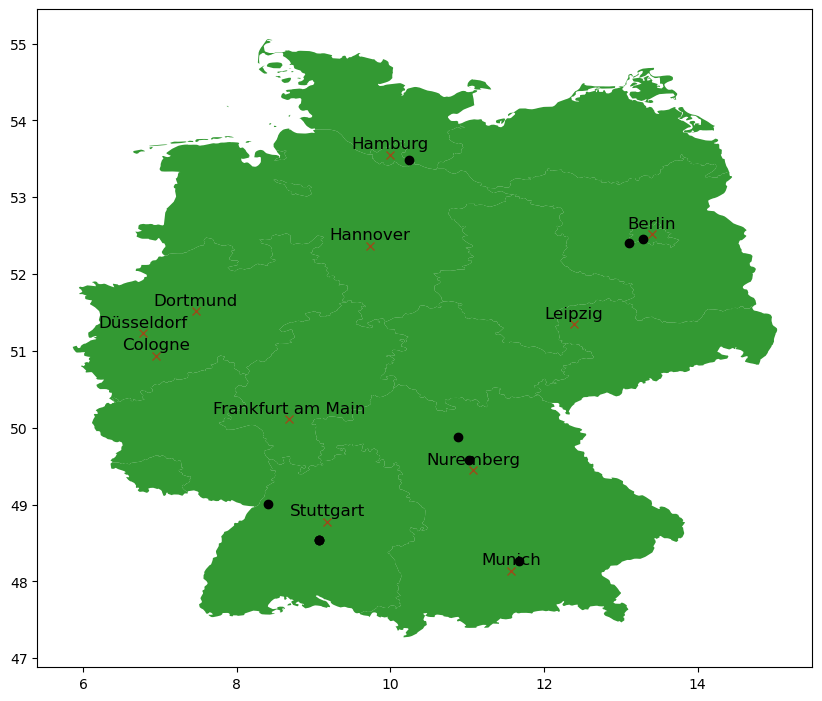

In [25]:
bld.plot(aspect='equal',color='green',alpha=0.8,figsize=(10,10))
plt.plot(res.lon,res.lat,'ko')
ax = plt.gca()
for c in top_cities.keys():
    # Plot city name.
    ax.text(
        x=top_cities[c][0], 
        # Add small shift to avoid overlap with point.
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )
    # Plot city location centroid.
    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='x',
        c='red', 
        alpha=0.5
    )

Embeddings can also be used as weighs for graph analyses etc. 


## Graph analysis

Speaking of graphs, GEPRIS data is inherently a typical tripartite graph (Persons/Projects/Institutions), so graph analysis is likely to be an important application. It can be used to identify collaboration networks, suggest potential collaborators etc. It is also probably more sensible to use graph information rather than simple vector similarity search on embeddings for more complex queries, but of course doing it in pandas directly is a bit cumbersome. Let us create a smaller dataset (let's say last 5 years) to ingest in a proper graph database like neo4j. But before moving to database, let us define the schema. As already mentioned, we have following entities/properties/relations:

- Person:
    - Name and id
    - knowledge area
    - gender
    - affiliation (relation institution)
    - projects (relation to projects)
- Project:
    - Title
    - Description
        - embedding
    - Knowledge area 
    - Principal investigator (first of CO-Is)
        - Co-investigators (relation to persons)
    - timeframe (start/stop)
    - Budget
    - parent project(s) (relation to other projects)
    - child project(s) (relation to other projects)
- Institution:
    - Name
    - relation to location
- Location (country -> bundesland -> city -> institution)
- Subject knowledge area
- DFG funding program type

these need to be ingested to the database, i.e. serialized first

Now we can connect to the database. Ensure that setup (local/managed) is correct for your case. I roughly followed this [medium post](https://towardsdatascience.com/neo4j-cypher-python-7a919a372be7)

In [366]:
import os, dotenv
from neo4j import GraphDatabase

from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))

class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

Add some constraints to ensure that nodes are uniquely identified and no duplicates are present in the database:

First, let's add program types, take unique value and drop n/a, then use a helper function to ingest the data:

In [367]:
subjects = pd.DataFrame([(x[0],x[1][0],x[1][1]) for x in fachgebiete.items()], columns=['subject_area_code', 'subject_de','subject_en'])

def add_subject(subjects):
    # Adds knowledge area nodes to the Neo4j graph.
    query = '''
            UNWIND $rows AS row
            MERGE (s:subject {subject_area_code: row.subject_area_code, subject_de: row.subject_de, subject_en: row.subject_en})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':subjects.to_dict('records')})

For projects and persons it's a bit more complicated as 140k projects and 100k persons + relations will not fit in free limits, so we need to slim it down a bit. Lets limit to the last 5 years:

In [368]:
recent_projects = df_projects[df_projects['start']>=2019].reset_index(drop=True)
unique_pis = set(recent_projects['PIs'].sum()) # take only PIs which are part of recent projects
recent_persons = df_persons[df_persons['person_id'].apply(lambda x: x in unique_pis)].reset_index(drop=True)
recent_persons = recent_persons.dropna(subset=['project_ids','affilation','lat','subject_area_code']).reset_index(drop=True)

Another thing is that we now want to use hosting institution (including its location) as separate node type, so we need to 
1) make a dataframe listing institutions including their adress (country/bundesland/city/coordinates)
2) assign an institution to each person in our list. Again, only include institutions listed in recent projects

As already mentioned, there is a problem of inconsistently formatted affiliations, which means that in some cases same place might formally correspond to different institutions. One way to solve this issue is to do geographical filtering as done above, but it's not optimal. Proper cleaning is time consuming and perhaps would require either manual verificaiton of adresses or use of agentic LLMs to check whether given affiliation makes sence using web data. As that's a bit too excessive for the current illustrative project, I'll just use unique affiliations as is:

In [369]:
institutions = recent_persons.drop_duplicates(subset=['affilation'])[['affilation','country','Bundesland','city','subject_area_code','lon','lat']].reset_index(drop=True)
institutions['institution_id'] = institutions.index
idx_map = institutions.set_index('affilation')['institution_id'].to_dict()
df_persons['institution_id'] = df_persons['affilation'].map(idx_map)
institutions['subject_area_code'] = institutions['subject_area_code'].fillna(-1).astype(np.int8) # convert to int to save space
institutions['Bundesland'] = institutions['Bundesland'].fillna('N/A')
institutions['city'] = institutions['city'].fillna('N/A')
institutions['lon'] = institutions['lon'].fillna(0)
institutions['lat'] = institutions['lat'].fillna(0)

In [370]:
institutions

,affilation,country,Bundesland,city,subject_area_code,lon,lat,institution_id
0,Österreichische Akademie der Wissenschaften IM...,at,N/A,Wien,22,16.401994,48.189450,0
1,"Technische Universität München, TUM School of ...",de,Bayern,Freising,22,11.724997,48.402225,1
2,Leibniz-Institut für Gewässerökologie und Binn...,de,Brandenburg,Rheinsberg,34,13.030608,53.141246,2
3,"Max-Planck-Institut für Mikrostrukturphysik, E...",de,Sachsen-Anhalt,Halle (Saale),32,11.940931,51.495502,3
4,"Justus-Liebig-Universität Gießen, Fachbereich ...",de,Hessen,Gießen,32,8.674121,50.569113,4
...,...,...,...,...,...,...,...,...
18466,"Otto-Friedrich-Universität Bamberg, Fachgruppe...",de,Bayern,Bamberg,12,10.904204,49.907387,18466
18467,Université de Genève Faculté de Médecine,ch,N/A,Genève,22,6.151301,46.193289,18467
18468,"Universität Bielefeld, Fakultät für Chemie, Ar...",de,Nordrhein-Westfalen,Bielefeld,21,8.493223,52.037689,18468
18469,"Medizinische Hochschule Hannover, Zentrum Anat...",de,Niedersachsen,Hannover,22,9.804456,52.383480,18469


In [371]:
import time

def add_institutions(rows, batch_size=10000):
    # Adds person nodes to the Neo4j graph as a batch job.
    # properties are ['person_id','name','gender','affilation_id']
    query = '''
            UNWIND $rows AS row
            MERGE (i:institution {institution_id: row.institution_id})
              ON CREATE SET
                    i.name = row.affilation,
                    i.country = row.country,
                    i.bundesland = row.Bundesland,
                    i.city = row.city,
                    i.lon = row.lon,
                    i.lat = row.lat
            WITH row, i
            UNWIND row.subject_area_code AS subject_code
                MATCH (s:subject {subject_area_code: subject_code})
                MERGE (i)-[:IN_SUBJECT_AREA]->(s)
            RETURN count(*) as total
            '''
    return insert_data(query, rows, batch_size)


def add_persons(rows, batch_size=10000):
    # Adds person nodes to the Neo4j graph as a batch job.
    # properties are ['person_id','name','gender','affilation_id']
    query = '''
            UNWIND $rows AS row
            MERGE (p:person {person_id: row.person_id})
            ON CREATE SET
            p.name = row.name,
            p.gender = row.gender
            WITH row, p
                UNWIND row.institution_id AS institution_id  
                MATCH (i:institution {institution_id: institution_id})
                MERGE (p)-[:AFFILIATED_WITH]->(i)    
            WITH row, p
                UNWIND row.subject_area_code AS subject_code
                MATCH (s:subject {subject_area_code: subject_code})
                MERGE (p)-[:IN_SUBJECT_AREA]->(s)
            RETURN count(*) as total
            '''
    return insert_data(query, rows, batch_size)

def add_projects(rows, batch_size=10000):
    # Adds person nodes to the Neo4j graph as a batch job.
    # properties are ['person_id','name','gender','affilation_id']
    query = '''
            UNWIND $rows AS row
            MERGE (p:project {project_id: row.project_id})
            ON CREATE SET
                p.title = row.title,
                p.description = row.description,
                p.program_type = row.program_type,
                p.start = row.start,
                p.stop = row.stop,
                p.duration = row.duration,
                p.estimated_budget = row.estimated_budget,
                p.embedding = row.embedding
            WITH row, p
                UNWIND row.subject_area_code AS subject_code
                MATCH (s:subject {subject_area_code: subject_code})
                MERGE (p)-[:IN_SUBJECT_AREA]->(s)
            WITH row, p
                UNWIND row.PIs AS pi_id
                MATCH (per:person {person_id: pi_id}) 
                MERGE (p)-[:PROPOSED_BY]->(per)
            RETURN count(*) as total
            '''
    return insert_data(query, rows, batch_size)



def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    
    total = 0
    batch = 0
    start = time.time()
    result = None
    
    while batch * batch_size < len(rows):

        res = conn.query(query, 
                         parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, 
                  "batches":batch, 
                  "time":time.time()-start}
        print(result)
        
    return result

In [372]:
conn = Neo4jConnection(uri=URI, 
                       user=AUTH[0],              
                       pwd=AUTH[1])
conn.query('CREATE CONSTRAINT persons IF NOT EXISTS FOR (p:person) REQUIRE p.person_id IS UNIQUE')
conn.query('CREATE CONSTRAINT projects IF NOT EXISTS FOR (p:project) REQUIRE p.project_id IS UNIQUE')
conn.query('CREATE CONSTRAINT institutions IF NOT EXISTS FOR (i:institution) REQUIRE i.institution_id IS UNIQUE')

[]

In [373]:
add_subject(subjects)

[<Record total=14>]

In [374]:
add_institutions(institutions.explode('institution_id'))

{'total': 9666, 'batches': 1, 'time': 10.967932939529419}
{'total': 17852, 'batches': 2, 'time': 19.438280820846558}


{'total': 17852, 'batches': 2, 'time': 19.438280820846558}

Now we need to add projects and connect projects. The scheme is knowledge area -> institution -> person -> project

In [375]:
add_persons(recent_persons.explode('person_id'))

{'total': 9673, 'batches': 1, 'time': 14.43683671951294}
{'total': 19320, 'batches': 2, 'time': 28.13215684890747}
{'total': 29025, 'batches': 3, 'time': 41.2641236782074}
{'total': 33148, 'batches': 4, 'time': 46.50645399093628}


{'total': 33148, 'batches': 4, 'time': 46.50645399093628}

In [377]:
recent_projects = recent_projects.dropna(subset=['project_id','title','start','stop','duration','estimated_budget','embedding'])
recent_projects = recent_projects[recent_projects['PIs'].apply(lambda x: len(x)>0)]

In [378]:
add_projects(recent_projects.explode('project_id'),batch_size=500) # ensure batch is 

{'total': 1309, 'batches': 1, 'time': 15.155874252319336}
{'total': 2614, 'batches': 2, 'time': 30.178399085998535}
{'total': 3730, 'batches': 3, 'time': 44.43069911003113}


Failed to write data to connection ResolvedIPv4Address(('34.76.245.87', 7687)) (ResolvedIPv4Address(('34.76.245.87', 7687)))
Failed to write data to connection IPv4Address(('074350e3.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.76.245.87', 7687)))


{'total': 4843, 'batches': 4, 'time': 59.89767098426819}
{'total': 5917, 'batches': 5, 'time': 77.62372899055481}
{'total': 7137, 'batches': 6, 'time': 96.71352887153625}
{'total': 8342, 'batches': 7, 'time': 111.3147759437561}
{'total': 9595, 'batches': 8, 'time': 126.80442309379578}
{'total': 10948, 'batches': 9, 'time': 142.33428311347961}
{'total': 12180, 'batches': 10, 'time': 157.05939316749573}
{'total': 13409, 'batches': 11, 'time': 171.17089295387268}
{'total': 14607, 'batches': 12, 'time': 185.938462972641}
{'total': 15827, 'batches': 13, 'time': 200.43683791160583}
{'total': 17249, 'batches': 14, 'time': 214.95246505737305}
{'total': 18370, 'batches': 15, 'time': 230.78861808776855}
{'total': 19554, 'batches': 16, 'time': 245.17637419700623}
{'total': 20595, 'batches': 17, 'time': 259.7768769264221}
{'total': 21756, 'batches': 18, 'time': 274.34133195877075}
{'total': 22916, 'batches': 19, 'time': 288.8067591190338}
{'total': 24073, 'batches': 20, 'time': 303.64495182037354}

{'total': 64603, 'batches': 56, 'time': 815.3224160671234}

With database uploaded, we can then do some funny things, including exploratory no-code analysis with [Neo4j Blook](https://neo4j.com/product/bloom/) or NetworkX in notebooks, but graph plotting is a bit time consuming, so I prefer the former option for interactive stuff.
But we also can query database directly, for instance, we can easily find all people involved in projects where a given person is involved:

In [396]:
collaborators_of_a_person = lambda FamilyName: f"collaborators of {FamilyName}: " + ", ".join([x['p2.name'] for x in conn.query(f"""MATCH (p1:person)
WHERE p1.name CONTAINS "{FamilyName}"
MATCH (p1)<-[:PROPOSED_BY]-(pr:project)-[:PROPOSED_BY]->(p2:person)
WHERE p1 <> p2
MATCH (p2)<-[:PROPOSED_BY]-(pr2:project)
RETURN DISTINCT p2.name""")])

collaborators_of_a_person("Sasaki")

'collaborators of Sasaki: Dr. Gerd  Pühlhofer, Professorin Dr. MariaRosa  Cioni, Ph.D., Dr. Frank  Haberl, Professor Dr. Werner  Becker, Privatdozent Dr. Axel  Schwope, Dr. Sara  Saeedi, Professor Dr. Jörn  Wilms, Professorin Dr. Beate  Stelzer, Professor Dr. Andrea  Santangelo, Dr. Michael  Freyberg, Professor Dr. Jürgen H.M.M.  Schmitt'

Or we can get names and descriptions of all projects where given institution (for instance, IAAT) is involved:

In [400]:
query = """MATCH (i:institution {name: "Eberhard Karls Universität Tübingen, Institut für Astronomie und Astrophysik, Abteilungen Astronomie und Hochenergieastrophysik"})<-[:AFFILIATED_WITH]-(p:person)<-[:PROPOSED_BY]-(pr:project)
RETURN p.name,pr.title,pr.description"""
res = conn.query(query)
res

[<Record p.name='Dr. Gerd  Pühlhofer' pr.title='SupernovaÜberreste im eROSITA AllSky Survey' pr.description='In der ersten Förderperiode der Forschungsgruppe FOR 2990 haben wir begonnen, anhand von eRASS-Daten nach noch unbekannten Supernova-Überreste (SNRs) in unserer Milchstraße im Röntgenband zu suchen und bekannte SNR-Kandidaten vom ROSAT All-Sky Survey und H.E.S.S. Galactic plane survey zu untersuchen. Wir werden die systematische Untersuchung der SNRs in unserer Milchstraße fortsetzen und dabei die eRASS-Daten mit neuesten Daten vom ASKAP EMU/POSSUM-Survey und MeerKAT Galactic plane radio survey kombinieren. Wir werden auch eRASS-Daten mit Gamma-Daten kombinieren, um Teilchenbeschleunigung in SNRs zu untersuchen. Nachdem die SNR-Population in den Magellanschen Wolken analysiert wurden, werden wir die Suche und Studien auf das Magellansche System erweitern.'>,
 <Record p.name='Dr. Gerd  Pühlhofer' pr.title='FOR 2990: eROSITAStudien zu Endstadien der Sterne (eROSTEP)' pr.descriptio

We can even get a summary of all the work done by the group using OpenAI API: 

In [421]:
concatenated_project_description = "\n".join(list((set([x['p.name'] +'\n' + x['pr.description'] for x in res])))) # drop duplicates to save tokens

In [422]:
concatenated_project_description

'Professor Dr. Klaus  Werner\nDie große Mehrheit aller Sterne beendet ihr Leben als weißer Zwerg. Abhängig von der Vorgeschichte findet man zwei unterschiedliche Klassen, eine mit wasserstoffreichen und eine mit heliumreichen Atmosphären. Sie werden als sehr heiße Objekte geboren (Effektivtemperatur etwa 200.000 K) und kühlen über Jahrmilliarden hinweg auf einige 1000 K ab. Entlang dieser Abkühlsequenz ändern die weißen Zwerge das Aussehen ihrer Spektren, was auf die Änderung der chemischen Zusammensetzung ihrer Atmosphären zurückzuführen ist.  Diese spektrale Entwicklung wird durch das Wechselspiel verschiedener Prozesse, wie zum Beispiel Strahlungsauftrieb und Gravitationstrennung der Elemente, sowie Massenverlust und Akkretion von Material von externen Quellen, bestimmt. Das vorgeschlagene Projekt zielt darauf ab, die spektrale Entwicklung einer kleinen Untergruppe wasserstoffreicher weißer Zwerge zu verstehen, den sogenannten Hybrid-Weißen-Zwergen, die sowohl Wasserstoff als auch H

In [423]:
from openai import OpenAI
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "You are a highly qualified scientific assistant who coincisely summarises input texts in english formatted as markdown."},
    {"role": "user", "content": f"provide a coincise summary of scientific activities of a research group based on the following research proposal abstract recently submitted by group members. You group projects by scientific topics and try to give a broad overview rather than lots of details. You mention who does what and try to generalize and mention main scientific questions, methods, facilities and collaborators: {concatenated_project_description}"}
  ]
)

completion = completion.choices[0].message

In [424]:
from IPython.display import display, Markdown
display(Markdown(completion.content))

### Summary of Scientific Activities by Research Group

#### White Dwarf Stars
- **Professor Dr. Klaus Werner** focuses on the cooling sequence and spectral evolution of hydrogen-rich white dwarfs, specifically hybrid white dwarfs. The study involves quantitative analysis of optical and ultraviolet spectra and aims to locate these stars on the Hertzsprung-Russell diagram using Gaia data to deduce their stellar parameters.

#### Neutron Stars and X-ray Bursts
- **Professor Dr. Klaus Werner** also investigates neutron star parameters to understand nucleon interactions in dense matter. This includes analyzing photospheric radius expansion X-ray bursts and modeling neutron star atmospheres to study chemical composition and interactions with accretion streams.

#### X-ray Binaries and Pulsars
- **Professor Dr. Andrea Santangelo** and **Dr. Victor Doroshenko** aim to expand the catalog of X-ray binary candidates with neutron stars or black holes using eROSITA data, enhancing our understanding of their luminosity function and spatial distribution in the Milky Way.
- **Professor Dr. Andrea Santangelo** and **Dr. Victor Doroshenko** also study accreting X-ray pulsars as laboratories for extreme conditions, utilizing blind source separation techniques to dissect their complex emissions.

#### Supernova Remnants
- **Dr. Gerd Pühlhofer** continues systematic investigations of supernova remnants (SNRs) using eRASS data, complementing with data from ASKAP EMU/POSSUM, MeerKAT, and gamma-ray surveys to study particle acceleration in SNRs.

#### Cataclysmic Variables
- **Professorin Dr. Beate Stelzer** focuses on understanding cataclysmic variables (CVs) using eRASS data to create and analyze complete samples of various CV classes, testing population synthesis models and the impact of magnetism on their evolution.

#### X-ray Emission from Galaxies
- **Professorin Dr. Beate Stelzer** and **Dr. Gerd Pühlhofer** contribute to the eRO-STEP (FOR 2990) group aiming to understand X-ray emissions from galactic sources and diffuse X-ray emissions using eROSITA sky survey data.

#### Young Stars and Planet Formation
- **Professorin Dr. Beate Stelzer** is part of projects like ULLYSES and PENELLOPE, utilizing multi-wavelength datasets to study young stars and their circumstellar disks, focusing on stellar and accretion properties, outflows, dust properties, and the interaction between mass outflows and accretion rates.

#### Ultralcool Dwarfs
- **Professorin Dr. Beate Stelzer** investigates the magnetic activity of ultracool dwarfs (UCDs) and their transitional behavior. By leveraging eROSITA, TESS, and other datasets, she aims to identify the physical origins of observed magnetic activity patterns in UCDs.

#### Super Soft X-ray Sources
- **Professor Dr. Klaus Werner** examines super soft X-ray sources (SSS) with eROSITA to resolve discrepancies in the observed and predicted populations, better characterizing nova populations, and improving white dwarf model atmospheres.

#### Polarimetry of Isolated Neutron Stars
- **Professor Dr. Klaus Werner** plans to investigate the polarization properties of X-ray emissions from isolated neutron stars (INS), including central compact objects (CCOs), X-ray INSs, and magnetars, using upcoming X-ray polarimetry missions (IXPE, eXTP).

### Methods and Facilities
- Quantitative spectral and photometric analyses, modeling of stellar atmospheres, use of Gaia, eROSITA, NICER, HST, VLT, TESS, XMM-Newton, and JVLA.
- Collaboration with international all-sky surveys, observational follow-ups with various telescopes, and theoretical modeling.

### Collaborations
- **Gaia** for precision distance measurements
- **ULLYSES and PENELLOPE** for multi-wavelength observations of young stars
- **eROSITA** for X-ray sky surveys and identifying populations of X-ray sources
- **ASKAP EMU/POSSUM, MeerKAT, and gamma-ray surveys** for SNR studies.
  
### Conclusion
The research group employs a diverse array of observational techniques and theoretical models to advance our understanding of various stellar objects' life cycles and interactions, leveraging international collaborations and cutting-edge facilities.